In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scTRS tools
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Constants 
DATA_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
OUT_PATH=DATA_PATH+'/results/fig_simu'

# GS 
GS_LIST = ['%s_ngene%d'%(prefix, size) for prefix in ['all', 'highmean', 'highvar', 'highbvar']
           for size in [100, 500, 1000]]
temp_dic = {'all': 'random genes', 'highmean': 'random high mean-expr genes',
            'highvar': 'random high variance genes', 'highbvar': 'random overdispersed genes'}
DIC_GS_NAME = {x:x.split('_')[1].replace('ngene','')+' '+temp_dic[x.split('_')[0]] 
               for x in GS_LIST}

# DATA_LIST
DATA_LIST = ['tms_facs.ncell_10k']

# Results 
DIC_RES_PATH = {'sctrs': DATA_PATH+'/simulation_data/score_file/@d.@g',
                'seurat': DATA_PATH+'/simulation_data/score_file/result_scanpy/@d.@g',
                'vision': DATA_PATH+'/simulation_data/score_file/result_vision/@d.@g',
                'vam': DATA_PATH+'/simulation_data/score_file/result_vam/@d.@g.tsv'}

METHOD_LIST = list(DIC_RES_PATH.keys())
DIC_METHOD_NAME = {'sctrs':'scDRS', 'seurat': 'Seurat', 'vision':'Vision', 'vam':'VAM'}
DIC_METHOD_COLOR = {'sctrs':'C0', 'seurat': 'C1', 'vision':'C2', 'vam':'C3'}

for method in METHOD_LIST:
    if method not in DIC_METHOD_NAME.keys():
        DIC_METHOD_NAME[method] = method
    if method not in DIC_METHOD_COLOR.keys():
        DIC_METHOD_COLOR[method] = 'C%d'%len(DIC_METHOD_COLOR)

In [3]:
# Read results 
import itertools

q_list = 10**np.linspace(-3,0,30)
dic_res = {}

for gs,dname,method in itertools.product(GS_LIST, DATA_LIST, METHOD_LIST):
    print(gs,dname,method)
    
    df_gs = pd.read_csv(DATA_PATH+'/simulation_data/gs_file/%s.gs'%gs, sep='\t', index_col=0)
    df_res = pd.DataFrame(index=df_gs.index, columns=q_list, data=-1)

    # load scTRS results 
    if method=='sctrs':
        for trait in df_gs.index:
            score_file = DIC_RES_PATH[method].replace('@d',dname).replace('@g',gs) + '/%s.score.gz'%trait
            if os.path.exists(score_file):
                temp_df = pd.read_csv(score_file, sep='\t')
                df_res.loc[trait, q_list] = np.quantile(temp_df['pval'], q_list)
            else:
                print('# file missing: ', score_file)
        dic_res['%s:%s:%s'%(dname,gs,method)] = df_res.copy()
            
    # load vam results 
    if method=='vam':
        score_file = DIC_RES_PATH[method].replace('@d',dname).replace('@g',gs) 
        if os.path.exists(score_file):
            temp_df = pd.read_csv(score_file, sep='\t')
            temp_df.columns = [x.replace('.','_') for x in temp_df.columns]
            drop_list = temp_df.columns[temp_df.mean(axis=0)>0.99]
            for trait in df_gs.index:
                if trait in drop_list: 
                    print('# %s dropped'%trait)
                    continue
                df_res.loc[trait, q_list] = np.quantile(temp_df[trait], q_list)
            df_res = df_res.loc[(df_res==-1).sum(axis=1)==0]
            dic_res['%s:%s:%s'%(dname,gs,method)] = df_res.copy()
        else:
            print('# file missing: ', score_file)
            
    # load vision result        
    if method=='vision':
        for trait in df_gs.index:
            score_file = DIC_RES_PATH[method].replace('@d',dname).replace('@g',gs) + '/%s.score.gz'%trait
            if os.path.exists(score_file):
                temp_df = pd.read_csv(score_file, sep='\t')
                df_res.loc[trait, q_list] = np.quantile(temp_df['norm_pval'], q_list)
            else:
                print('# file missing: ', score_file)
        dic_res['%s:%s:%s'%(dname,gs,method)] = df_res.copy()
        
    # load seurat results
    if method=='seurat':
        for trait in df_gs.index:
            score_file = DIC_RES_PATH[method].replace('@d',dname).replace('@g',gs) + '/%s.score.gz'%trait
            if os.path.exists(score_file):
                temp_df = pd.read_csv(score_file, sep='\t')
                df_res.loc[trait, q_list] = np.quantile(temp_df['pval'], q_list)
            else:
                print('# file missing: ', score_file)
        dic_res['%s:%s:%s'%(dname,gs,method)] = df_res.copy()

all_ngene100 tms_facs.ncell_10k sctrs
all_ngene100 tms_facs.ncell_10k seurat
all_ngene100 tms_facs.ncell_10k vision
all_ngene100 tms_facs.ncell_10k vam
all_ngene500 tms_facs.ncell_10k sctrs
all_ngene500 tms_facs.ncell_10k seurat
all_ngene500 tms_facs.ncell_10k vision
all_ngene500 tms_facs.ncell_10k vam
all_ngene1000 tms_facs.ncell_10k sctrs
all_ngene1000 tms_facs.ncell_10k seurat
all_ngene1000 tms_facs.ncell_10k vision
all_ngene1000 tms_facs.ncell_10k vam
highmean_ngene100 tms_facs.ncell_10k sctrs
highmean_ngene100 tms_facs.ncell_10k seurat
highmean_ngene100 tms_facs.ncell_10k vision
highmean_ngene100 tms_facs.ncell_10k vam
highmean_ngene500 tms_facs.ncell_10k sctrs
highmean_ngene500 tms_facs.ncell_10k seurat
highmean_ngene500 tms_facs.ncell_10k vision
highmean_ngene500 tms_facs.ncell_10k vam
highmean_ngene1000 tms_facs.ncell_10k sctrs
highmean_ngene1000 tms_facs.ncell_10k seurat
highmean_ngene1000 tms_facs.ncell_10k vision
highmean_ngene1000 tms_facs.ncell_10k vam
highvar_ngene100 tms

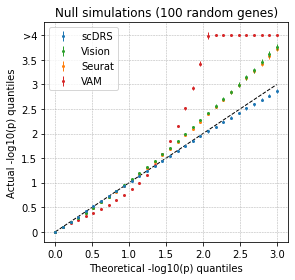

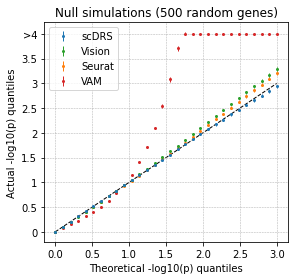

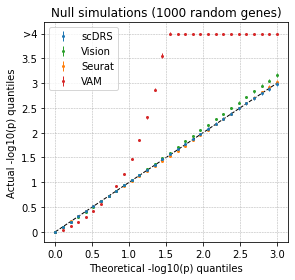

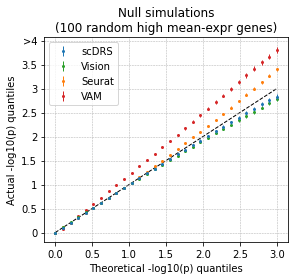

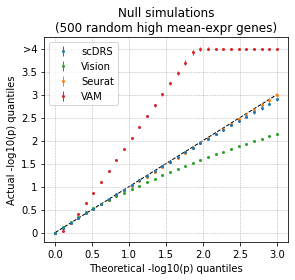

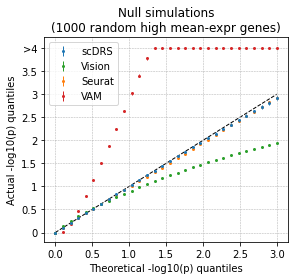

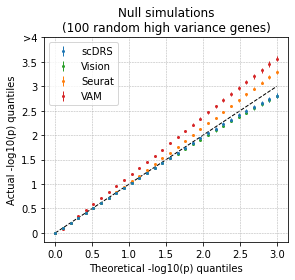

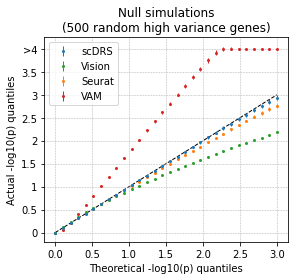

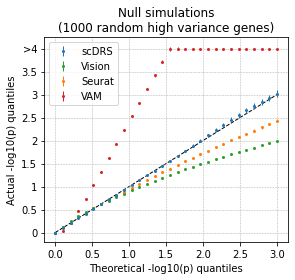

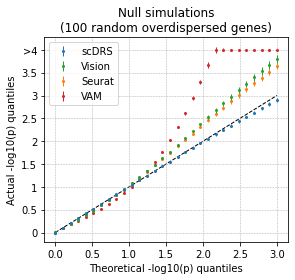

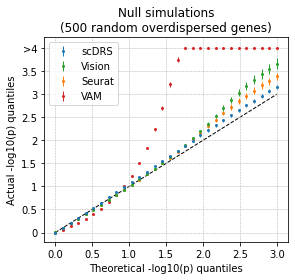

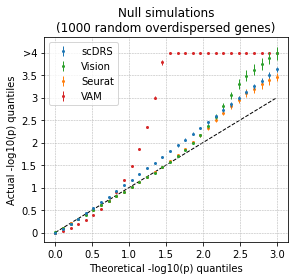

In [4]:
# Q-Q plot
dname = 'tms_facs.ncell_10k'
plot_list = ['%s:%s'%(dname, x) for x in GS_LIST]
plot_method_list = ['sctrs', 'vision', 'seurat', 'vam']

for plot_name in plot_list:
    dname,gs=plot_name.split(':')
    df_plot_mean = pd.DataFrame(index=q_list, columns=plot_method_list, data=-1)
    df_plot_se = pd.DataFrame(index=q_list, columns=plot_method_list, data=-1)
    
    for method in plot_method_list:
        res = '%s:%s'%(plot_name,method)
        temp_df = dic_res[res][q_list].loc[(dic_res[res][q_list]==-1).sum(axis=1)==0]
        
        df_plot_mean.loc[q_list, method] = temp_df.mean(axis=0)
        df_plot_se.loc[q_list, method] = temp_df.std(axis=0)/np.sqrt(temp_df.shape[0])
        
    df_plot_mean = df_plot_mean.clip(lower=1e-4)
    df_plot_se = df_plot_se.clip(lower=1e-10)    
    
    # Compute distance and p-value
    df_plot_dist = np.absolute(np.log10(df_plot_mean.T)-np.log10(df_plot_mean.index)).T
    df_plot_dist.drop(1, axis=0, inplace=True)
    df_plot_dist = df_plot_dist.max(axis=0)
    
    temp_df = np.absolute(df_plot_mean.T-df_plot_mean.index).T / df_plot_se
    df_plot_p = pd.DataFrame(index=df_plot_mean.index, columns=df_plot_mean.columns, 
                             data=(1-sp.stats.norm.cdf(temp_df))*2)
    df_plot_p.drop(1, axis=0, inplace=True)
    df_plot_p = df_plot_p.median(axis=0)
    
    # Plot 
    plt.figure(figsize=[4.2,4])
    df_plot_logerr = np.log10(df_plot_mean+1.96*df_plot_se) - np.log10(df_plot_mean)
    for i_method,method in enumerate(plot_method_list):
        plt.errorbar(-np.log10(df_plot_mean.index), -np.log10(df_plot_mean[method]), 
                     yerr = df_plot_logerr[method], label=DIC_METHOD_NAME[method],
                     fmt='.', markersize=4, elinewidth=1, color=DIC_METHOD_COLOR[method], zorder=8-i_method)

    plt.plot([0, 3], [0, 3], linestyle='--', linewidth=1, color='k', zorder=0)
    plt.xlabel('Theoretical -log10(p) quantiles')
    plt.ylabel('Actual -log10(p) quantiles')
    plt.yticks([0,0.5,1,1.5,2,2.5,3,3.5,4],[0,0.5,1,1.5,2,2.5,3,3.5,'>4'])
    plt.grid(linestyle='--', linewidth=0.5)
    if 'all' in gs:
        plt.title('Null simulations (%s)'%DIC_GS_NAME[gs])
    else:
        plt.title('Null simulations\n(%s)'%DIC_GS_NAME[gs])
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUT_PATH+'/%s.%s.svg'%(dname,gs))
    plt.show()
    
    # Store data for the main figure 'tms_facs.ncell_10k:all_ngene1000'
    if plot_name=='tms_facs.ncell_10k:all_ngene1000':
        SUPP_TAB_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/supp_table'
        df_plot_mean.columns = ['%s.mean'%x for x in df_plot_mean]
        df_plot_se.columns = ['%s.se'%x for x in df_plot_se]
        df_out = df_plot_mean.join(df_plot_se)
        df_out.index.name='quantile'
        df_out = df_out[['%s.%s'%(x,y) for x in plot_method_list for y in ['mean', 'se']]]
        df_out.to_csv(SUPP_TAB_PATH+'/supp_tab_fig2a.tsv', sep='\t')

In [5]:
for method in plot_method_list:
    print(method, (np.log10(df_out['%s.mean'%method]+1.96*df_out['%s.se'%method])
                   - np.log10(df_out['%s.mean'%method])).max())

sctrs 0.03840265567895207
vision 0.039289529620924135
seurat 0.03902260206418218
vam 0.0428203965511309


### Cell type-disease association 

In [6]:
# Load single-cell data
adata = sc.read_h5ad(DATA_PATH+'/simulation_data/single_cell_data/tms_facs.ncell_10k.h5ad')

# Read full score
dic_res_full = {}
score_file=DATA_PATH+'/simulation_data/score_file/tms_facs.ncell_10k.all_ngene1000'
df_gs = pd.read_csv(DATA_PATH+'/simulation_data/gs_file/all_ngene1000.gs', sep='\t', index_col=0)
for trait in df_gs.index:
    if os.path.exists(score_file+'/%s.full_score.gz'%trait):
        dic_res_full[trait] = pd.read_csv(score_file+'/%s.full_score.gz'%trait, sep='\t', index_col=0)
    else:
        print('# file missing: ', score_file)

In [7]:
# Cell type-disease association 
celltype_list = sorted(set(adata.obs['cell_ontology_class']))
trait_list = list(df_gs.index)
df_stats = pd.DataFrame(index=celltype_list, columns=trait_list, dtype=float)
for trait in trait_list:
    for ct in celltype_list:
        cell_list = adata.obs_names[adata.obs['cell_ontology_class']==ct]
        temp_df = dic_res_full[trait].loc[cell_list].copy()
        score_q95 = np.quantile(temp_df['norm_score'], 0.95)
        temp_df = temp_df[[x for x in temp_df.columns if x.startswith('ctrl_norm_score')]]
        v_ctrl_score_q95 = np.quantile(temp_df, 0.95, axis=0)
        df_stats.loc[ct,trait] = ((v_ctrl_score_q95>=score_q95).sum()+1) / (v_ctrl_score_q95.shape[0]+1)

In [8]:
df_stats_fdr = df_stats.copy()
print('# n_celltype=%d, n_rep=%d'%df_stats_fdr.shape)
for col in df_stats_fdr:
    df_stats_fdr[col] = multipletests(df_stats[col], method='fdr_bh')[1]
for alpha in [0.05, 0.1, 0.2]:
    v_fd = (df_stats_fdr<alpha).sum(axis=0)
    v_d = v_fd.clip(lower=1)
    v_fdp = v_fd / v_d
    print('# alpha=%0.2f, FDP=%0.3f (SE=%0.3f)'
          %(alpha, v_fdp.mean(), 1.96*v_fdp.std()/np.sqrt(df_stats_fdr.shape[1])))

# n_celltype=118, n_rep=100
# alpha=0.05, FDP=0.000 (SE=0.000)
# alpha=0.10, FDP=0.020 (SE=0.028)
# alpha=0.20, FDP=0.180 (SE=0.076)
